# Porirua spatial analysis with slope

In [3]:
# Install support package and dependencies 
!pip install --upgrade -e ../.

# Ensure access to packge for imports
import sys
sys.path.append('../')

Obtaining file:///home/jovyan/work/osm/osmnx-catchments
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: osmcatch
    Found existing installation: osmcatch 0.0.1
    Uninstalling osmcatch-0.0.1:
      Successfully uninstalled osmcatch-0.0.1
  Running setup.py develop for osmcatch


## Get walk network and slope

We obtain the walk network from OpenStreetMaps using the `osmnx` and `osmnxcatch` Python libraries for the Porirua City using StatsNZ local authority boundary. The walk network is defined using the following osm tags and is extracted for a specified date for repeatability.

```
walk_highways = '["area"!~"yes"]["highway"]' + \
    '["highway"!~"motorway"]' + \
    '["highway"!~"motorway_junction"]' + \
    '["highway"!~"traffic_signals"]["highway"!~"give_way"]' + \
    '["foot"!~"no"]' + \
    '["sidewalk"!~"no|separate"]["area"!~"yes"]'
walk_footways = '["area"!~"yes"]["footway"]'
```

NB: The osm walking network and tags have been reviewed as part of this process. THe areas around Porirua city centre, Porirua Station and Kenepuru Station have been reviewed to date and updated to ensure the above tags return an accurate walk network. 


Walk network loaded from file


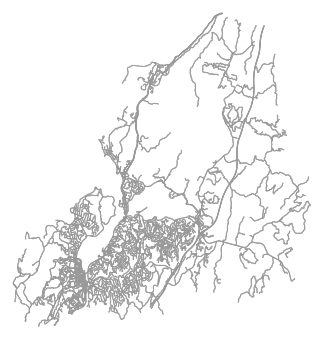

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [4]:
from osmcatch import network
import osmnx as ox

def get_walk_network(from_cache=False):

    if from_cache == True:
        try:
            walk = network.WalkNetwork.load_graph('input_data/walk_network_graph_1_osm.gpickle.gz')
            print('Walk network loaded from file')
        except:
            from_cache = False
            print('Could not load walk network from file, will create from osm')
    
    if from_cache != True:
        # Define point within Porirua
        access_point = (-41.1377659, 174.8432213) # Porirua Station Entrance 1

        # Get local authority walk network
        G = network.get_osm_walk_network(access_point, 
                                         snapshot_date="2021-06-01T12:00:00Z",
                                         return_local_authority_network=True)
        walk = network.WalkNetwork(G)
        print('Walk network created from osm')
        
        # Save network
        walk.save_graph('input_data/walk_network_graph_1_osm.gpickle.gz')
        
    return walk
    
walk = get_walk_network(from_cache=True)

# Optional, plot network
walk.plot_graph(bgcolor="white", node_size=0, figsize=(6,6))

Once we get the walk network we want to determine the slopes which are to be used to adjust walk speeds. We used the LINZ [Wellington region DEM 2013/14](https://data.linz.govt.nz/layer/53621-wellington-lidar-1m-dem-2013-2014/) dataset for this purpose. Due to the number of data points there is no suiable API to query the DEM data directly. The DEM data was downloaded for area `Territorial Authorities = "Porirua City"` using `crs=2193` and saved to a local folder `/spatial_data/linz_dem_2013_porirua`. This is not included in version control as around 700MB in size.

The DEM raster data is processed and the above graph updated with elevations and gradients. The graph is then saved so can opened up directly in future, without having to reprocess the DEM files which may not be available.

In [6]:
from osmcatch import elevation, network
from pathlib import Path

def add_walk_network_elevations(G=None, from_cache=False):

    if from_cache == True:
        try:
            walk = network.WalkNetwork.load_graph('input_data/walk_network_graph_2_elevation.gpickle.gz')
            print('Network elevations loaded from file')
        except:
            from_cache = False
            print('Could not load network elevations from file, will create from raster files')
    
    if from_cache != True:
 
        # Path to raster data 
        dem_path = 'spatial_data/linz_dem_2013_porirua/'
        dem_path = Path.home().joinpath(Path(dem_path))

        # Process all tiles adding elevations to graph
        dem_tile_paths = list(dem_path.glob("DEM*.tif"))
        G2 = elevation.add_elevations_to_graph(G, 
                                               raster_path=dem_tile_paths,
                                               raster_crs='epsg:2193')
        walk = network.WalkNetwork(G2)
        print('Walk network created from raster files')
        
        # Save network
        walk.save_graph('input_data/walk_network_graph_2_elevation.gpickle.gz')

    return walk
        
walk = add_walk_network_elevations(from_cache=True)    
#walk = add_walk_network_elevations(G=walk.graph, from_cache=False)

Walk network created from raster files


The followings show a histogram of slope (rise over run) on left and elevation (m) on right. The slope is a log scale as dominated by near zero slope. The elevation histogram shows most nodes have a near zero elevation (above sea level). 

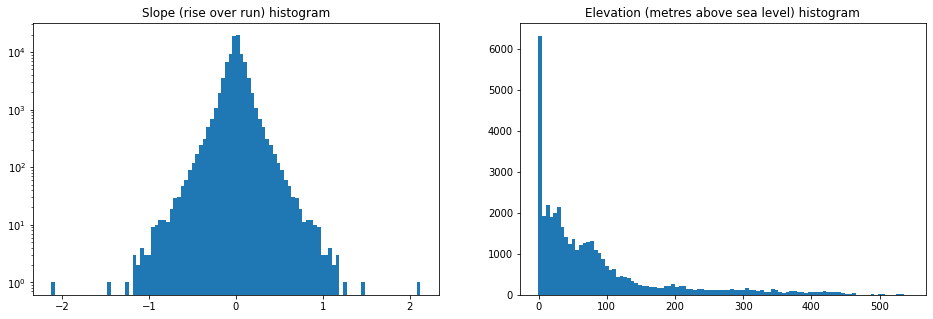

In [7]:
import matplotlib.pyplot as plt

bins = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

data = walk.edges['grade'].dropna()
_ = ax1.hist(data, bins=bins, log=True)
_ = ax1.set_title('Slope (rise over run) histogram')

data = walk.nodes['elevation'].dropna()
_ = ax2.hist(data, bins=bins)
_ = ax2.set_title('Elevation (metres above sea level) histogram')


We do a manual calculation to check how the gradient is calculated.

In [12]:
y1 = walk.nodes.loc[170503846,'elevation']
y2 = walk.nodes.loc[6095246412,'elevation']
run, grade = walk.edges.loc[(170503846, 6095246412, 0), ('length', 'grade')]

import math
# calc gradient from points to check result
calc_grade = round((y2-y1)/run, 3) 

# convert to degrees
calc_deg = math.degrees(math.atan(calc_grade))

assert grade == calc_grade

## Impact of slope on walk speeds

### Slope adjusted walk speed formulation

The impact of slope on walk speeds is not clearly understood. There are some empirical studies although these focus mainly on hiking [Cambel et al (2019) Using crowdsourced fitness tracker data to model the relationship between slope and travel rates](https://doi.org/10.1016/j.apgeog.2019.03.008) with the impact of slope largely governed by rules-of-thumb such as Tobler's hiking function (Campbell et al). There is also a body of health research looking at areas such as impact of speed on ambulatory motion [Koo S, Park MS, Chung CY, Yoon JS, Park C, Lee KM 2019) Effects of walking speed and slope on pedobarographic findings in young healthy adults](https://pubmed.ncbi.nlm.nih.gov/31454402/).

Waka Kotahi NZ Transport Agency are currently updating the pedestrian planning and design guide. It is unknown whether this will change the assumptions regarding walk speeds. The [NZ Transport Agency (2009) Pedestrian planning and design guide](https://www.nzta.govt.nz/resources/pedestrian-planning-guide/) states the following regarding speeds (section 3.4):

```
The vast majority of people walk at speeds between 0.8 metres per second (m/s) and
1.8 m/s (2.9 kilometres per hour (km/h) and 6.5 km/h) [139]. A fit, healthy adult will
generally travel at a mean speed of 1.5 m/s (15th percentile (15%ile): 1.3 m/s), and
the aged and those with mobility impairments travel more slowly, at around 1.2 m/s
(15%ile: 1.0 m/s)
```

The following references are cited in teh planning and design guide but have not been reviewed as sit behind a paywall.
- [Knoblauch, R. L, M. T. Pietrucha, and M. Nitzburg (1996) *Field studies of pedestrian walking speed and start-up time*. Transportation Research Record 1538.](https://doi.org/10.1177%2F0361198196153800104)
- [Milazzo, J. S., N. M. Rouphail, J. E. Hummer, and D. P. Allen (1999) *Quality of Service for Uninterrupted-Flow Pedestrian Facilities in Highway Capacity Manual 2000*](https://doi.org/10.3141%2F1678-03)

The [Transportation Research Board (2000) *Highway capacity manual*](http://www.trb.org/Main/Blurbs/Highway_Capacity_Manual_2010_HCM2010_164718.aspx) states that the free-flow speed of pedestrians on a footpath is approximalye 1.5 m/s with a a uphill gradient of 10% or more reducing walking speed by 0.1 m/s (page 18-1). The 1.5 m/s speed is an often quoted rule of thumb with 1.5 m/s converting to 5.4 km/h and a change of 0.1 m/s converting to 0.36 km/h. More recent versions of the *Highway capacity manual* have not been reviewed as sitting behind a paywall. 

The most comprehensive and recent look at the impact of slope on walk speed is [Campbell et al (2019) Using crowdsourced fitness tracker data to model the relationship between slope and travel rates](https://doi.org/10.1016/j.apgeog.2019.03.008). This paper looks at a number of gradient/walk speed functions and recommends the *Lorentz* formulation using the 5th percentile. The formulation is as follows, but unfortunately the paper does not recommend parameter values:

$$
  V_{Lorentz} = c \left( \frac{1}{\pi b \left[1 + \left( \frac{\theta - a}{b} \right) ^2 \right] } \right) + d + e \theta
$$ (Lorentz formulation)

where

- $V$ represents travel rate in m/s
- $\theta$ represents slope in degrees
- $a$ represents a curve-centering term (akin to the mean of the distribution)
- $b$ represents a curve-width-widening term (akin to the standard deviation of the distribution)
- $c$ is an additional multiplicative term as travel rate data are bounded by [0,10]
- $d$ is additive term requires as none of the travel rate percentiles reach zero
- $e$ is a final slope-dependent multiplicative term allowing for anisotropy in uphill and downhill travel rates

Given the lack of evidence on paramter values a simplified formulation is required.

Other references
- [Finnis & Walton (nd) *Field observations of factors influencing walking speeds*. New Zealand]
- [Joaquín Márquez-Pérez, Ismael Vallejo-Villalta & José I. Álvarez-Francoso (2017) Estimated travel time for walking trails in natural areas, Geografisk Tidsskrift-Danish Journal of Geography, 117:1, 53-62, DOI: 10.1080/00167223.2017.1316212](https://www.tandfonline.com/doi/full/10.1080/00167223.2017.1316212)
- [James G. Colclough & Eric Owens (2010) Mapping Pedestrian Journey Times using a Network-based GIS Model, Journal of Maps, 6:1, 230-239, DOI: 10.4113/jom.2010.1075](https://www.tandfonline.com/doi/abs/10.4113/jom.2010.1075)
- [Irmischer, I., & Clarke, K. (2018). Measuring and modeling the speed of human navigation. CARTOGRAPHY AND GEOGRAPHIC INFORMATION SCIENCE, 45(2), 177-186](http://dx.doi.org/10.1080/15230406.2017.1292150)

Irmischer & Clarke (2017) seems likely candidate for a formula. THe following being the Irmischer model of on-road navigation speed for males

$$
  Speed_{m/s} = 0.11 + e^\left(\frac{-(Slope + 5)^2}{2 * 30^2}\right)
$$ (Irmischer formulation)

where

- $Slope = \Delta elevation / \Delta distance * 100$

The Irmischer formulation is derived from a study of 200 military personel within a rural setting where the terrain is hilly and wooded. This is likley not directly applicable to the urban environment, although the impact of slope on the on-road navigation formulation is possibly generalisable. It is proposed that the Irmischer formulation be used but the maximium walking speed of 1.11 m/s (4.0 km/h) be adjusted to use a slightly higher walking speed of 1.5 m/s (5.4 km/h) based on the literature for average urban walking speeds, noting hte maximum speed will be reach on a slight downhill gradient (of 5%). 

The following shows the Irmischer formulation with the original max_speed of 1.11 m/s and hte revised formulation iwth max_speed of 1.5 m/s.

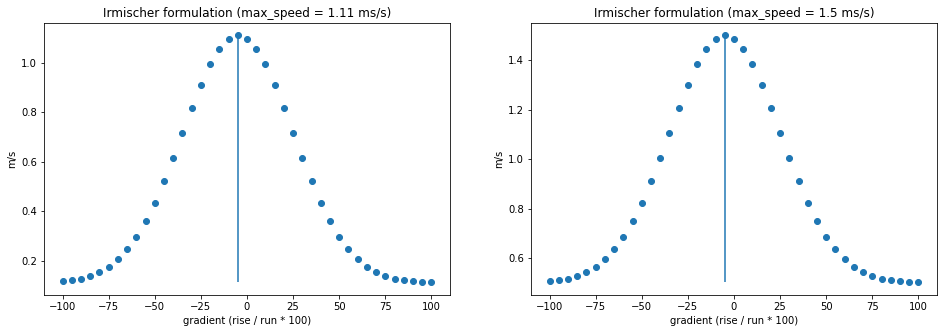

In [3]:
from osmcatch import elevation
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

s = range(-100,105,5) 

v = elevation.gradient_adjusted_walk_speed(s, max_speed=1.11, unit='m/s')
_ = ax1.scatter(x=s, y=v)
_ = ax1.set_title('Irmischer formulation (max_speed = {} ms/s)'.format(round(max(v),2)))
_ = ax1.set_ylabel("m/s")
_ = ax1.set_xlabel("gradient (rise / run * 100)")
_ = ax1.vlines(-5, ymin=min(v), ymax=max(v))

v = elevation.gradient_adjusted_walk_speed(s, max_speed=1.5, unit='m/s')
_ = ax2.scatter(x=s, y=v)
_ = ax2.set_title('Irmischer formulation (max_speed = {} ms/s)'.format(round(max(v),2)))
_ = ax2.set_ylabel("m/s")
_ = ax2.set_xlabel("gradient (rise / run * 100)")
_ = ax2.vlines(-5, ymin=min(v), ymax=max(v))


### Apply slope adjustment to walk speed and return walk time in minutes

Now that we have determined the correct walk speed function we will update the walk network with gradient adjusted speeds. The first few rows are shown below .

In [8]:
walk.add_edge_speed()
walk.save_graph('input_data/walk_network_graph_3_speed.gpickle.gz')
#walk = network.WalkNetwork.load_graph('input_data/walk_network_graph_3_speed.gpickle.gz')

walk.edges.head()[['grade','speed','length','walk_mins']]

grade   speed   length  walk_mins
u         v         key                                   
53353242  200460119 0    0.024  1.4700   62.759   0.711553
          200483401 0   -0.026  1.4968  112.832   1.256369
200460119 53353242  0   -0.024  1.4963   62.759   0.699047
          185970107 0    0.027  1.4676   47.420   0.538521
200483401 200486123 0   -0.032  1.4982    8.210   0.091332

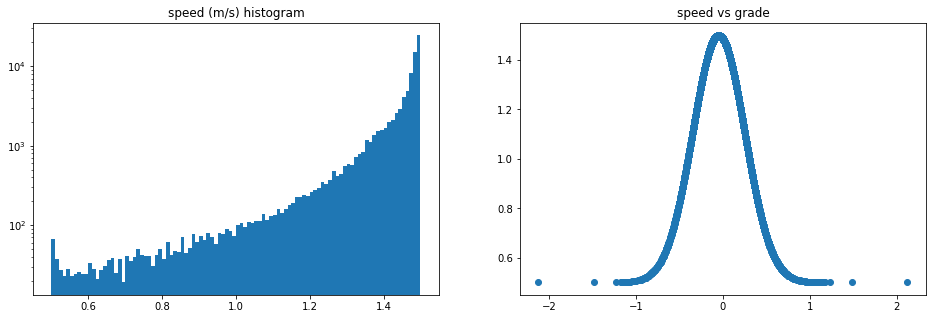

In [10]:
import matplotlib.pyplot as plt

bins = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

speed = walk.edges[['speed']]
_ = ax1.hist(speed, bins=bins, log=True)
_ = ax1.set_title('speed (m/s) histogram')

grade = walk.edges[['grade']]
_ = ax2.scatter(x=grade, y=speed)
_ = ax2.set_title('speed vs grade')


## Plot catchments

In [ ]:
from osmcatch import plot

plot.plot_station('Plimmerton Station', [(-41.083889, 174.867259),(-41.083906, 174.867066)])

In [1]:
from osmcatch import network
walk = network.WalkNetwork.load_graph('input_data/walk_network_graph_3_speed.gpickle.gz')

In [2]:
a = walk.iso_bands(access_points = [(-41.149628, 174.838112)],
                   location_name = "Kenepuru Station",
                   iso_bands_mins = [5, 10])
a

,location_name,access_points,access_nodes,iso_band_mins,geometry
0,Kenepuru Station,"[(-41.149628, 174.838112)]",[4303462223],10,"POLYGON ((174.83428 -41.15250, 174.83426 -41.1..."
1,Kenepuru Station,"[(-41.149628, 174.838112)]",[4303462223],5,"POLYGON ((174.83407 -41.15182, 174.83408 -41.1..."


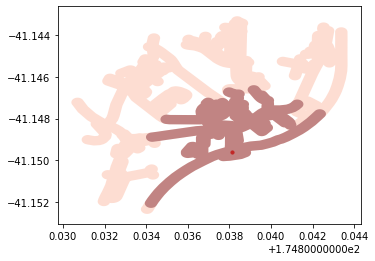

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [3]:
walk.plot_iso_bands(a)

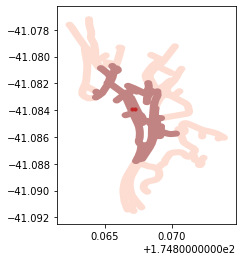

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [4]:
walk.plot_station([(-41.083889, 174.867259),(-41.083906, 174.867066)], 'Plimmerton Station')